In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import yahoo_fin.stock_info as si

import talib
from mplfinance.original_flavor import candlestick_ohlc

from matplotlib.pylab import date2num

In [2]:
import sys
sys.version

'3.8.6 (default, Nov 20 2020, 18:29:40) \n[Clang 12.0.0 (clang-1200.0.32.27)]'

In [3]:
cols = ['open', 'high', 'low', 'close', 'adjclose', 'volume', 'ticker']
cols_to_drop = ["Date", "adjclose", "ticker"]
cols_to_exclude = []#["volume"]

cols_to_keep = [i for i in cols if i not in cols_to_drop]

# cols_to_keep = list(set(cols).difference(cols_to_drop).difference(cols_to_exclude))
cols_to_keep

['open', 'high', 'low', 'close', 'volume']

In [4]:
def get_indicators(data):
    # Get MACD
    data["macd"], data["macd_signal"], data["macd_hist"] = talib.MACD(data['close'])
    
    # Get MA10 and MA30
    data["ma10"] = talib.MA(data["close"], timeperiod=10)
    data["ma30"] = talib.MA(data["close"], timeperiod=30)
    
    # Get RSI
    data["rsi"] = talib.RSI(data["close"])
    
    #Get the Average True Range
    data['ATR'] = talib.ATR(data['high'], data['low'], data['close'])
    
    return data.dropna()

In [5]:
def plot_chart(data, n, ticker, save=False):
    
    # Filter number of observations to plot
    data = data.iloc[-n:]
    
    # Create figure and set axes for subplots
    fig = plt.figure()
    fig.set_size_inches((20, 16))
    ax_candle = fig.add_axes((0, 0.72, 1, 0.32))
    ax_macd = fig.add_axes((0, 0.48, 1, 0.2), sharex=ax_candle)
    ax_rsi = fig.add_axes((0, 0.24, 1, 0.2), sharex=ax_candle)
    ax_vol = fig.add_axes((0, 0, 1, 0.2), sharex=ax_candle)
    
    # Format x-axis ticks as dates
    ax_candle.xaxis_date()
    
    # Get nested list of date, open, high, low and close prices
    ohlc = []
    for date, row in data.iterrows():
        openp, highp, lowp, closep = row[:4]
        ohlc.append([date2num(date), openp, highp, lowp, closep])
 
    # Plot candlestick chart
    ax_candle.plot(data.index , data["close"], label="Closing" ,linewidth=2,)
    ax_candle.plot(data.index, data["ma10"], label="MA10")
    ax_candle.plot(data.index, data["ma30"], label="MA30")
    candlestick_ohlc(ax_candle, ohlc, colorup="g", colordown="r", width=0.8)
    ax_candle.legend()
    
    # Plot MACD
    ax_macd.set_ylabel("MACD")
    ax_macd.plot(data.index, data["macd"], label="macd")
    ax_macd.bar(data.index, data["macd_hist"] * 3, label="hist")
    ax_macd.plot(data.index, data["macd_signal"], label="signal")
    ax_macd.legend()
    
    # Plot RSI
    # Above 70% = overbought, below 30% = oversold
    ax_rsi.set_ylabel(" RSI (%)")
    ax_rsi.plot(data.index, [70] * len(data.index), label="overbought")
    ax_rsi.plot(data.index, [30] * len(data.index), label="oversold")
    ax_rsi.plot(data.index, data["rsi"], label="rsi")
    ax_rsi.legend()
    
    # Plot ATR --> Volatility
    ax_vol.set_ylabel("Volatility")
    ax_vol.plot(data.index, data["ATR"], label="Average True Range")
    ax_vol.legend()
    
    # Save the chart as PNG
    if save:
        fig.savefig(path + ticker + ".jpeg", bbox_inches="tight", dpi=300)
    
    plt.show()

In [6]:
#2005-07-28
stocks = {"YESBANK.NS" : 0.2, "TATAMOTORS.NS":0.2, "HDFCBANK.NS":0.2, "RELIANCE.NS":0.2,"BAJAJ-AUTO.NS":0.2}
df = None
indices = set([])

for stock in stocks.keys():
    _df = si.get_data(stock)
    _df.dropna(inplace=True)
    if df is None:
        df = _df[cols_to_keep]*stocks.get(stock)
        indices = set(df.index.astype('str').tolist())
    else:
        indices = indices.intersection(set(_df.index.astype('str').tolist()))
        df = df.loc[indices]
        _df = _df.loc[indices]
        df[cols_to_keep] += _df[cols_to_keep]*stocks.get(stock)

df.head()

,open,high,low,close,volume
2015-12-11,798.654990,799.977988,781.429990,785.994000,9053313.6
2013-10-03,632.177400,655.234605,626.290800,653.076781,17756694.2
2019-05-10,1150.186011,1162.599982,1138.426031,1143.069995,21586791.8
2020-02-07,1215.600008,1221.289994,1195.530025,1204.600016,36360595.0
2017-08-17,1054.175000,1061.130017,1040.762000,1045.004016,5131065.4


In [7]:
df.index.min(), df.index.max()
_df.columns

Index(['open', 'high', 'low', 'close', 'adjclose', 'volume', 'ticker'], dtype='object')

In [8]:
# df = pd.read_csv("/Users/maitreyasinha/IIT-B Course/Data Mining/StockPricePrediction/GoogleStockPricePrediction/GOOG2.csv")
# df = pd.read_csv("/Users/maitreyasinha/IIT-B Course/Data Mining/StockPricePrediction/Algorithmic-trading/TATAMOTORS.NS test.csv")
# df.head()

In [9]:
df.dropna(inplace=True)
df = df.reset_index()
df.rename(columns = {'index':'Date'}, inplace = True)
# df.drop(["volume"],axis=1,inplace=True)
df.head()

,Date,open,high,low,close,volume
0,2015-12-11,798.654990,799.977988,781.429990,785.994000,9053313.6
1,2013-10-03,632.177400,655.234605,626.290800,653.076781,17756694.2
2,2019-05-10,1150.186011,1162.599982,1138.426031,1143.069995,21586791.8
3,2020-02-07,1215.600008,1221.289994,1195.530025,1204.600016,36360595.0
4,2017-08-17,1054.175000,1061.130017,1040.762000,1045.004016,5131065.4


In [10]:
df["Date"].min(), df["Date"].max()

(Timestamp('2012-06-18 00:00:00'), Timestamp('2020-12-14 00:00:00'))

In [11]:
mdf = df[:100]
mdf.head()
print(len(mdf))
mdf.sort_values('Date')

100


,Date,open,high,low,close,volume
43,2012-07-06,504.598398,507.878795,498.090199,501.540187,7912097.4
34,2012-07-25,494.457405,501.074208,490.729004,497.709990,8301091.0
27,2012-07-27,504.251192,509.718805,497.588004,503.504198,7783300.6
61,2012-07-31,512.022787,516.878207,504.582191,513.372807,7846137.6
45,2012-08-21,543.826199,549.113208,541.598199,546.582399,5638764.4
...,...,...,...,...,...,...
94,2020-08-10,1267.850009,1278.699999,1251.380029,1260.590034,63318692.8
57,2020-08-24,1275.509961,1292.379990,1263.700006,1277.630029,79332345.0
82,2020-09-22,1293.350000,1299.249994,1263.150028,1275.740006,47697452.6
56,2020-11-06,1273.239999,1300.930001,1269.700004,1293.099990,40287132.6


,Date,open,high,low,close,volume
296,2012-06-18,498.057199,502.561600,487.347800,493.955995,8785219.8
1786,2012-06-19,493.474800,497.925006,489.002598,494.518608,6852061.0
374,2012-06-20,495.188400,498.892000,492.321605,496.167993,7471406.2
1513,2012-06-21,494.756209,500.059802,488.568991,496.253203,7786645.8
1494,2012-06-22,491.631396,501.192795,490.014796,497.120602,6448372.0


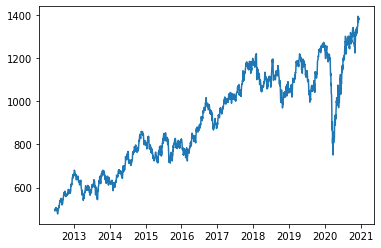

In [12]:
df= df.sort_values('Date')
split_date = '2020-01-01'
df_data_training = df[df["Date"]<split_date]
df_data_test = df[df["Date"]>=split_date]
plt.plot(df["Date"],df["open"])
df.head()

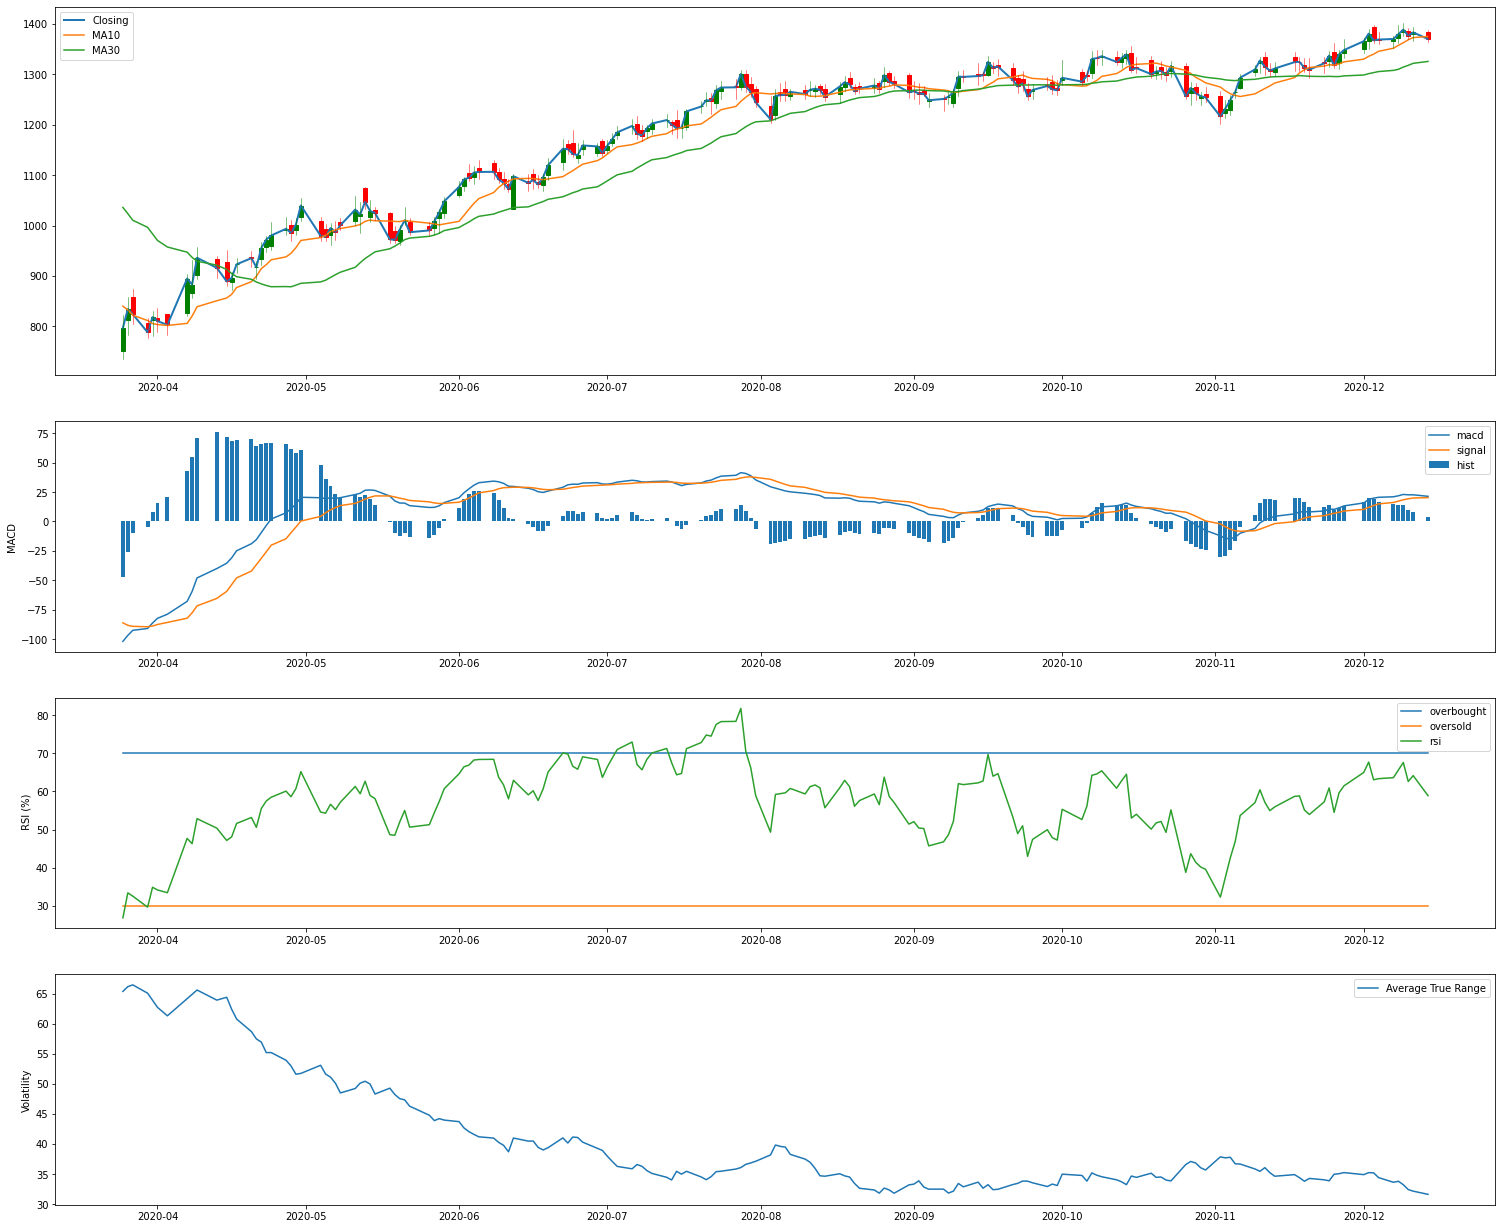

In [13]:
_df = df.set_index("Date")
_df = get_indicators(_df)
plot_chart(_df, 180, 'Custom')

In [14]:
df_data_training.head()
print("Training Size : {}, Test Size : {}".format(len(df_data_training), len(df_data_test)) )

Training Size : 1851, Test Size : 238


In [15]:
data_training = df_data_training.drop(["Date"], axis=1)
data_training.dropna(inplace=True)

In [16]:
scaler = MinMaxScaler()
training_Dataset = scaler.fit_transform(data_training)
training_Dataset.shape

(1851, 5)

In [17]:
training_window = 60
X_train = []
y_train = []
for i in range(training_window, training_Dataset.shape[0]):
    X_train.append(training_Dataset[i-training_window:i])
    y_train.append(training_Dataset[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)

In [18]:
print("Shape of X is : {}, Shape of Y is : {}".format(X_train.shape,y_train.shape))

Shape of X is : (1791, 60, 5), Shape of Y is : (1791,)


In [19]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
X_train.shape[1]
tf.optimizers

<module 'tensorflow.keras.optimizers' from '/usr/local/lib/python3.8/site-packages/tensorflow/keras/optimizers/__init__.py'>

In [20]:
model = Sequential([
    LSTM(units=120, activation='relu', return_sequences = True, input_shape = (60,5)),
    Dropout(0.2),
    LSTM(units=90, activation='relu', return_sequences = True),
    Dropout(0.2),
    LSTM(units=80, activation='relu', return_sequences = True),
    Dropout(0.2),
    LSTM(units=70, activation='relu'),
    Dropout(0.2),
    Dense(1)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 120)           60480     
_________________________________________________________________
dropout (Dropout)            (None, 60, 120)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 90)            75960     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 90)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 80)            54720     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 80)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 70)                4

In [21]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        if logs["loss"] < 1e-03:
            print("\nFinal Loss : {}".format(logs["loss"]))
            self.model.stop_training = True

In [22]:
X_train

array([[[0.02578229, 0.01540443, 0.02051927, 0.02017744, 0.04701432],
        [0.0200225 , 0.00952048, 0.02261872, 0.02088848, 0.03666897],
        [0.02217639, 0.01074762, 0.02682956, 0.02297302, 0.03998342],
        ...,
        [0.06337401, 0.06227734, 0.07058209, 0.07508124, 0.04489211],
        [0.07394108, 0.07056788, 0.08011184, 0.08186444, 0.02327603],
        [0.07815584, 0.07091001, 0.08091442, 0.08371974, 0.02746661]],

       [[0.0200225 , 0.00952048, 0.02261872, 0.02088848, 0.03666897],
        [0.02217639, 0.01074762, 0.02682956, 0.02297302, 0.03998342],
        [0.02163315, 0.01222959, 0.0220686 , 0.02308071, 0.04167043],
        ...,
        [0.07394108, 0.07056788, 0.08011184, 0.08186444, 0.02327603],
        [0.07815584, 0.07091001, 0.08091442, 0.08371974, 0.02746661],
        [0.08594558, 0.07590819, 0.08478501, 0.08337268, 0.03773051]],

       [[0.02217639, 0.01074762, 0.02682956, 0.02297302, 0.03998342],
        [0.02163315, 0.01222959, 0.0220686 , 0.02308071, 0.0

In [23]:
model.compile(optimizer= tf.optimizers.RMSprop() , loss= tf.losses.MeanSquaredError())
X_train.shape, y_train.shape
model.fit(X_train,y_train, epochs=4, callbacks = CustomCallback())

Epoch 1/4
56/56 [==============================] - 5s 93ms/step - loss: 0.0425
Epoch 2/4
56/56 [==============================] - 5s 91ms/step - loss: 0.0147
Epoch 3/4
56/56 [==============================] - 5s 92ms/step - loss: 0.0116
Epoch 4/4
56/56 [==============================] - 5s 92ms/step - loss: 0.0095


In [24]:
test_pred = model.predict(X_train)
model.evaluate(X_train, y_train)
test_pred.shape
# data_test.head()

56/56 [==============================] - 1s 24ms/step - loss: 0.0052


(1791, 1)

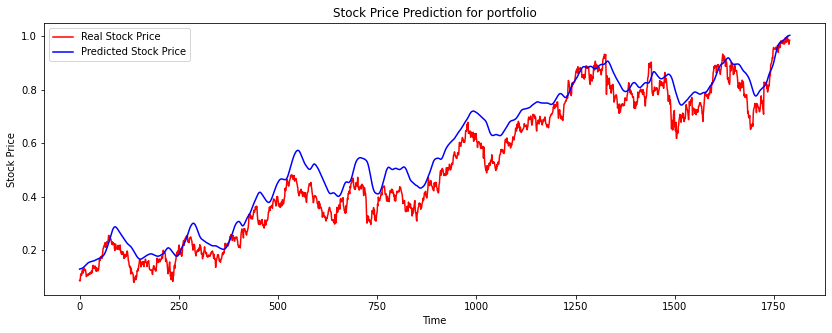

In [25]:
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_train, color = 'red', label = 'Real Stock Price')
plt.plot(test_pred, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction for portfolio')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
# plt.xlim(0,900)
# plt.ylim(0,2000)
plt.savefig("/Users/maitreyasinha/IIT-B Course/Data Mining/StockPricePrediction/Algorithmic-trading/training_output.jpeg", dpi=300)
plt.show()

In [24]:
past_60_days = df_data_training.tail(60)

In [25]:
df = past_60_days.append(df_data_test, ignore_index = True)
df = df.drop(['Date'], axis = 1)
df.dropna(inplace=True)
df.head()

,open,high,low,close,volume
0,1134.700000,1147.769990,1108.890015,1122.200015,173463121.4
1,1117.759991,1133.029990,1105.600005,1119.480000,132846895.4
2,1127.870010,1134.579991,1100.780006,1104.629996,112950881.2
3,1107.079966,1121.610015,1099.389985,1110.490010,81378225.8
4,1111.749986,1128.399995,1103.349999,1121.780025,81061969.6


In [26]:
inputs = scaler.transform(df)
# inputs

In [28]:
X_test = []
y_test = []

for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i])
    y_test.append(inputs[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

((237, 60, 5), (237,))

In [29]:
y_pred = model.predict(X_test)
y_pred.shape

(237, 1)

In [30]:
scaler.scale_

array([5.35152474e-09, 1.25693704e-03, 1.26902391e-03, 1.26870446e-03,
       1.26382407e-03])

In [31]:
scale = 1/scaler.scale_[0]
scale

186862632.39999998

In [32]:
y_pred = y_pred*scale
y_test = y_test*scale
y_pred.shape

(237, 1)

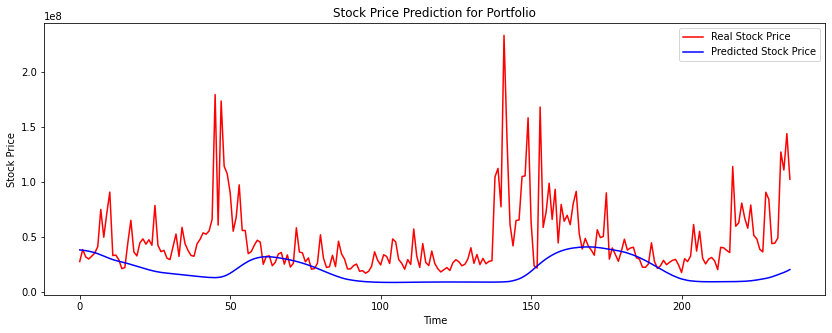

In [33]:
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_test, color = 'red', label = 'Real Stock Price')
plt.plot(y_pred, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction for Portfolio')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
# plt.xlim(0,900)
# plt.ylim(0,2000)
plt.savefig("/Users/maitreyasinha/IIT-B Course/Data Mining/StockPricePrediction/Algorithmic-trading/test_output.jpeg", dpi=300)
plt.show()